Processing data for Berlin from 1981-06-01 to 1981-08-31
Coordinates 52.5483283996582°N 13.407821655273438°E
Processing data for Berlin from 1982-06-01 to 1982-08-31
Coordinates 52.5483283996582°N 13.407821655273438°E
Processing data for Berlin from 1983-06-01 to 1983-08-31
Coordinates 52.5483283996582°N 13.407821655273438°E
Processing data for Berlin from 1984-06-01 to 1984-08-31
Coordinates 52.5483283996582°N 13.407821655273438°E
Processing data for Berlin from 1985-06-01 to 1985-08-31
Coordinates 52.5483283996582°N 13.407821655273438°E
Processing data for Berlin from 1986-06-01 to 1986-08-31
Coordinates 52.5483283996582°N 13.407821655273438°E
Processing data for Berlin from 1987-06-01 to 1987-08-31
Coordinates 52.5483283996582°N 13.407821655273438°E
Processing data for Berlin from 1988-06-01 to 1988-08-31
Coordinates 52.5483283996582°N 13.407821655273438°E
Processing data for Berlin from 1989-06-01 to 1989-08-31
Coordinates 52.5483283996582°N 13.407821655273438°E
Processing data for

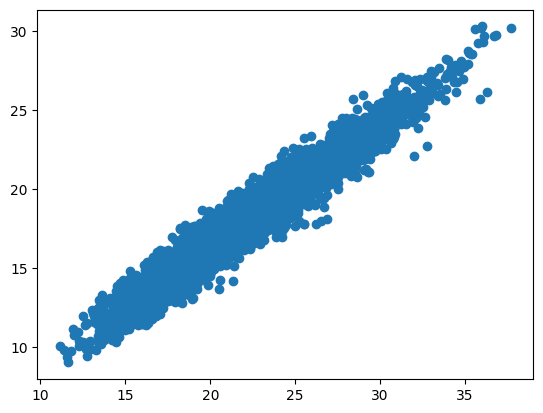

In [12]:
import openmeteo_requests
import requests_cache
import pandas as pd
from retry_requests import retry
import matplotlib.pyplot as plt

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after=-1)
retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
openmeteo = openmeteo_requests.Client(session=retry_session)

# List of locations and their coordinates
locations = [
    {"latitude": 52.52, "longitude": 13.41, "name": "Berlin"},
    {"latitude": 52, "longitude": 13.42, "name": "Location2"},
    # Add more locations as needed
]

# Start- und Endjahre definieren
start_year = 1981
end_year = 2010

# Leere Liste für die Zeiträume
time_periods = []

# Schleife über die Jahre, um Zeiträume zu erstellen
for year in range(start_year, end_year + 1):
    period = {
        "start_date": f"{year}-06-01",
        "end_date": f"{year}-08-31"
    }
    time_periods.append(period)

# Loop over locations and time periods to fetch data
all_hourly_data = []
all_daily_data = []

for location in locations:
    for period in time_periods:
        params = {
            "latitude": location["latitude"],
            "longitude": location["longitude"],
            "start_date": period["start_date"],
            "end_date": period["end_date"],
            "daily": ["temperature_2m_max", "temperature_2m_min", "temperature_2m_mean"],
            "models": "best_match"
        }

        # Fetch data from API
        responses = openmeteo.weather_api(url="https://archive-api.open-meteo.com/v1/archive", params=params)
        response = responses[0]  # Process first response (location and model)

        print(f"Processing data for {location['name']} from {period['start_date']} to {period['end_date']}")
        print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")


        # Process daily data
        daily = response.Daily()
        daily_temperature_2m_max = daily.Variables(0).ValuesAsNumpy()
        daily_temperature_2m_min = daily.Variables(1).ValuesAsNumpy()
        daily_temperature_2m_mean = daily.Variables(2).ValuesAsNumpy()

        daily_data = {
            "location": location["name"],
            "date": pd.date_range(
                start=pd.to_datetime(daily.Time(), unit="s", utc=True),
                end=pd.to_datetime(daily.TimeEnd(), unit="s", utc=True),
                freq=pd.Timedelta(seconds=daily.Interval()),
                inclusive="left"
            ),
            "temperature_2m_max": daily_temperature_2m_max,
            "temperature_2m_min": daily_temperature_2m_min,
            "temperature_2m_mean": daily_temperature_2m_mean
        }

        daily_dataframe = pd.DataFrame(data=daily_data)
        all_daily_data.append(daily_dataframe)

# Concatenate all data into single DataFrames for easier analysis
all_daily_df = pd.concat(all_daily_data, ignore_index=True)


print("Daily data:")
print(all_daily_df.head())

# Save to CSV or other formats
all_daily_df.to_csv('daily_temperature_data.csv', index=False)

plt.scatter(all_daily_df['temperature_2m_max'], all_daily_df['temperature_2m_mean'])